<a href="https://colab.research.google.com/github/Elhammostafa/Movie-Recommendation-using-unsupervised-learning/blob/main/movierecommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Examples.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>

# Introduction

The followig aims to get you up and running with the predict.
Make a copy of the notebook and run all cells. We will also show you how to get your submission file from kaggle.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Installing packages
Please download all relevant packages in. There is no terminal so you will pip install everything.

You can find a list of recommended install from the Intro to Recommender sysytem notebook.

In [ ]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

## Reading in data

In [ ]:
train_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/train.csv')
movies_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/movies.csv')
imdb_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/imdb_data.csv')
test_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/test.csv')
links_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/links.csv')
tags = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/tags.csv')
genome_scores = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/genome_scores.csv')
genome_tags = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/genome_tags.csv')
sample_submissions = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/sample_submission.csv')

In [ ]:
movies_df.head()

In [ ]:
movies_df.shape

## EDA


### Outliers
- **Identify outliers**: Outliers are data points that differ significantly from other observations. They can skew and mislead the training process of a machine learning model.
- **Detecting outliers**: Use statistical methods such as Z-scores or IQR (Interquartile Range) to detect outliers.
- **Handling outliers**: Decide whether to remove or transform the outliers depending on their impact on the dataset.

### Understanding Relationships Between Various Attributes and Structure of the Data
- **Correlation Analysis**: Use correlation matrices to understand the relationships between numerical attributes.
- **Visualization Techniques**: Employ scatter plots, pair plots, and heatmaps to visualize and explore relationships.
- **Data Structure**: Understand the structure of the data, including the distribution of values and the presence of any missing values.

### Recognizing Important Variables
- **Feature Importance**: Use techniques like Random Forests, Gradient Boosting, or SHAP values to determine feature importance.
- **Domain Knowledge**: Incorporate domain expertise to identify which variables are likely to be important.
- **Statistical Tests**: Conduct statistical tests to identify variables that have significant effects on the target variable.

By understanding the data through these steps, we ensure a robust foundation for building and evaluating machine learning models.


**Lets Check whether or not we have any missing values in our dataset**

In [ ]:
print("Train: ")
print(str(train_df.isnull().sum()))
print("************")
print("Test: ")
print(str(test_df.isnull().sum()))
print("************")
print("Movies: ")
print(str(movies_df.isnull().sum()))
print("************")
print("Links: ")
print(str(links_df.isnull().sum()))
print("************")
print("IMDB: ")
print(str(imdb_df.isnull().sum()))
print("************")
print("Genome scores: ")
print(str(genome_scores.isnull().sum()))
print("************")
print("Genome tags: ")
print(str(genome_tags.isnull().sum()))

## Data Preparation

Data preparation is the process of preparing raw data so that it is suitable for further processing and analysis. Key steps include:

- **Collecting**: Gathering raw data from various sources.
- **Cleaning**: Removing or correcting any errors or inconsistencies in the data. This includes handling missing values, correcting data types, and removing duplicates.
- **Labeling**: Annotating data with labels that are required for supervised machine learning tasks. This involves identifying and marking the target variable.
- **Transforming**: Converting raw data into a format that is suitable for analysis. This includes normalization, scaling, encoding categorical variables, and feature engineering.
- **Exploring**: Analyzing the data to understand its structure and relationships. This step includes generating descriptive statistics and visualizing the data to identify patterns and insights.
- **Visualizing**: Creating graphical representations of the data to better understand distributions, trends, and relationships among variables. Common techniques include histograms, bar charts, scatter plots, and heatmaps.

By following these steps, raw data is transformed into a structured format that is ready for machine learning algorithms and further analysis.


In [ ]:
movies_df.head()

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies_df[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

**Lets plot genres from most common to least common**

In [ ]:
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

## Modelling phase
 You only need to apply one version
be it Content based or Collabrative method



In [ ]:
import pandas as pd
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split

# Sample books data
books_data = {
    'bookId': [1, 2, 3, 4, 5, 6, 7],
    'title': ['To Kill a Mockingbird', '1984', 'The Great Gatsby', 'Pride and Prejudice', 'The Catcher in the Rye', 'Animal farm'
              ,'Harry Potter']
}

# Create the books DataFrame
books = pd.DataFrame(books_data)

# Sample user profiles
user_profiles = {
    1: {'bookId': [2, 3, 4], 'rating': [5, 4, 3]},
    2: {'bookId': [1, 3, 5], 'rating': [4, 5, 3]}
}

# Combine user profiles into a single DataFrame
all_ratings = []

for user_id, profile in user_profiles.items():
    for book_id, rating in zip(profile['bookId'], profile['rating']):
        all_ratings.append({'userId': user_id, 'bookId': book_id, 'rating': rating})

ratings_df = pd.DataFrame(all_ratings)

# Define the Reader and Dataset
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'bookId', 'rating']], reader)


## Lets Build and Evaluate Our Model

In [ ]:
# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2, )

# Train the SVD model
svd = SVD()
svd.fit(trainset)

# Make predictions on the test set
predictions = svd.test(testset)

# Compute and print the RMSE
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

pred = pd.DataFrame(predictions)
pred

## Recommendation Function

In [ ]:
# Function to get collaborative recommendations for a user profile
def get_collaborative_recommendations(user_id, svd, books, ratings_df, n=10):
    recommendations = []
    book_ids = books['bookId'].unique()

    for book_id in book_ids:
        prediction = svd.predict(user_id, book_id)
        actual_rating = ratings_df[(ratings_df['userId'] == user_id) & (ratings_df['bookId'] == book_id)]['rating']
        actual_rating = actual_rating.values[0] if not actual_rating.empty else None
        recommendations.append((books[books['bookId'] == book_id]['title'].values[0], prediction.est, actual_rating))

    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)

    return recommendations[:n]

# Generate recommendations for each user profile and collect them in a list
all_recommendations = []

for user_id in user_profiles.keys():
    recommendations = get_collaborative_recommendations(user_id, svd, books, ratings_df)
    for title, predicted_rating, actual_rating in recommendations:
        all_recommendations.append({
            'userId': user_id,
            'Recommended Book': title,
            'Predicted_Rating': predicted_rating,
            'Actual Rating': actual_rating
        })

# Convert the list of recommendations to a DataFrame
recommendations_df = pd.DataFrame(all_recommendations)

recommendations_df

# Generate your outputs here

Prepare Submission File
We make submissions in CSV files. Your submissions usually have two columns: an ID column and a prediction column. The ID field comes from the test data (keeping whatever name the ID field had in that data, which for the data is the string 'Id'). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's to_csv method to write our submission file. Explicitly include the argument index=False to prevent pandas from adding another column in our csv file.

In [ ]:
# This is an example
my_submission = pd.DataFrame({'id': recommendations_df.userId,'predict': recommendations_df.Predicted_Rating})
#you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

# Tips
- NB:Read the description well
    - REMEMBER: Concatenated ID
    - Evatualtion metrics
- Sampling is your friend -> start small and scale up
- Data ingestioon, pleasse ensure the correct path is dependant on the environment
- Ensure test output matches dimension of test set for Kaggle submission
- 20 Submissions per day
- This is individual project
- Ensure email correlates to Athena for effective tracking
- If you use a shuffler ensure test output aligns with test sample ordering
  - (from sklearn.utils import shuffle), for randomness
- Make sure your notebook is in the same folder
- Analyse your data well
- Make sure you have gone through your content


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Packages for modeling
import surprise
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq


# Step 1: Data Loading and Initial Exploration

# Load the datasets
train = pd.read_csv('/content/sample_data/Untitled/train.csv')
test = pd.read_csv('/path/to/test.csv')
movies = pd.read_csv('/path/to/movies.csv')
tags = pd.read_csv('/path/to/tags.csv')
links = pd.read_csv('/path/to/links.csv')
genome_scores = pd.read_csv('/path/to/genome_scores.csv')
genome_tags = pd.read_csv('/path/to/genome_tags.csv')
imdb_data = pd.read_csv('/path/to/imdb_data.csv')

# Display the first few rows of each dataset
print("Train Data:")
print(train.head())

print("\nTest Data:")
print(test.head())

print("\nMovies Data:")
print(movies.head())

print("\nTags Data:")
print(tags.head())

print("\nLinks Data:")
print(links.head())

print("\nGenome Scores Data:")
print(genome_scores.head())

print("\nGenome Tags Data:")
print(genome_tags.head())

print("\nIMDB Data:")
print(imdb_data.head())

# Step 2: Exploratory Data Analysis (EDA)

# Analyze the distribution of ratings
plt.figure(figsize=(10, 6))
train['rating'].hist(bins=50)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Visualize the number of ratings per user
ratings_per_user = train.groupby('userId').size()
plt.figure(figsize=(10, 6))
ratings_per_user.hist(bins=50)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

# Visualize the number of ratings per movie
ratings_per_movie = train.groupby('movieId').size()
plt.figure(figsize=(10, 6))
ratings_per_movie.hist(bins=50)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

# Explore relationships between different features (e.g., genres, tags)
genres = movies['genres'].str.get_dummies('|').sum().sort_values(ascending=False)
plt.figure(figsize=(14, 7))
genres.plot(kind='bar')
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

tags['tag'].value_counts().head(20).plot(kind='bar', figsize=(14, 7))
plt.title('Top 20 Tags')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.show()

# Step 3: Data Cleaning

# Check for missing values
print(train.isnull().sum())
print(test.isnull().sum())
print(movies.isnull().sum())
print(tags.isnull().sum())
print(links.isnull().sum())
print(genome_scores.isnull().sum())
print(genome_tags.isnull().sum())
print(imdb_data.isnull().sum())

# Example of handling missing values in IMDB data
imdb_data.fillna('', inplace=True)  # or use other imputation methods

# Ensure data types are correct
train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

# Encode genres as a list
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

# Step 4: Feature Engineering

# Example: Average rating per movie
movie_avg_rating = train.groupby('movieId')['rating'].mean().reset_index()
movie_avg_rating.columns = ['movieId', 'avg_rating']

# Example: Number of ratings per movie
movie_rating_count = train.groupby('movieId')['rating'].count().reset_index()
movie_rating_count.columns = ['movieId', 'rating_count']

# Merge these features with the original movies dataframe
movies = movies.merge(movie_avg_rating, on='movieId', how='left')
movies = movies.merge(movie_rating_count, on='movieId', how='left')

# Step 5: Model Building

# Load the data into Surprise format
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)

# Use SVD algorithm for recommendation
svd = SVD()

# Evaluate the model
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Step 6: Prediction and Submission

# Train the model on the entire dataset
trainset = data.build_full_trainset()
svd.fit(trainset)

# Predict ratings for the test set
test['rating'] = test.apply(lambda x: svd.predict(x['userId'], x['movieId']).est, axis=1)

# Create submission file
test['Id'] = test['userId'].astype(str) + '_' + test['movieId'].astype(str)
submission = test[['Id', 'rating']]

# Save to CSV
submission.to_csv('submission.csv', index=False)


ModuleNotFoundError: No module named 'surprise'

In [4]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357239 sha256=ac701af90e41a884345c53d01c4c1f4b22cf7c57ae8f620e9f91df4fc92cc054
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

# Step 1: Data Loading and Initial Exploration

# Load the datasets
train = pd.read_csv('/content/sample_data/train.csv')
test = pd.read_csv('/content/sample_data/test.csv')
movies = pd.read_csv('/content/sample_data/movies.csv')
tags = pd.read_csv('/content/sample_data/tags.csv')
links = pd.read_csv('/content/sample_data/links.csv')
genome_scores = pd.read_csv('/content/sample_data/genome_scores.csv')
genome_tags = pd.read_csv('/content/sample_data/genome_tags.csv')
imdb_data = pd.read_csv('/content/sample_data/imdb_data.csv')

In [6]:

# Display the first few rows of each dataset
print("Train Data:")
print(train.head())

print("\nTest Data:")
print(test.head())

print("\nMovies Data:")
print(movies.head())

print("\nTags Data:")
print(tags.head())

print("\nLinks Data:")
print(links.head())

print("\nGenome Scores Data:")
print(genome_scores.head())

print("\nGenome Tags Data:")
print(genome_tags.head())

print("\nIMDB Data:")
print(imdb_data.head())

Train Data:
   userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837

Test Data:
   userId  movieId
0       1     2011
1       1     4144
2       1     5767
3       1     6711
4       1     7318

Movies Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Tags Data:
   user

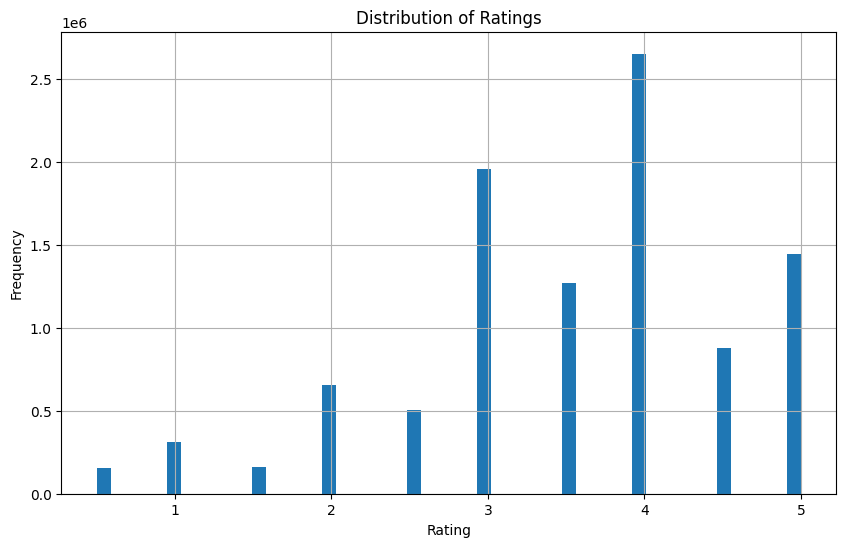

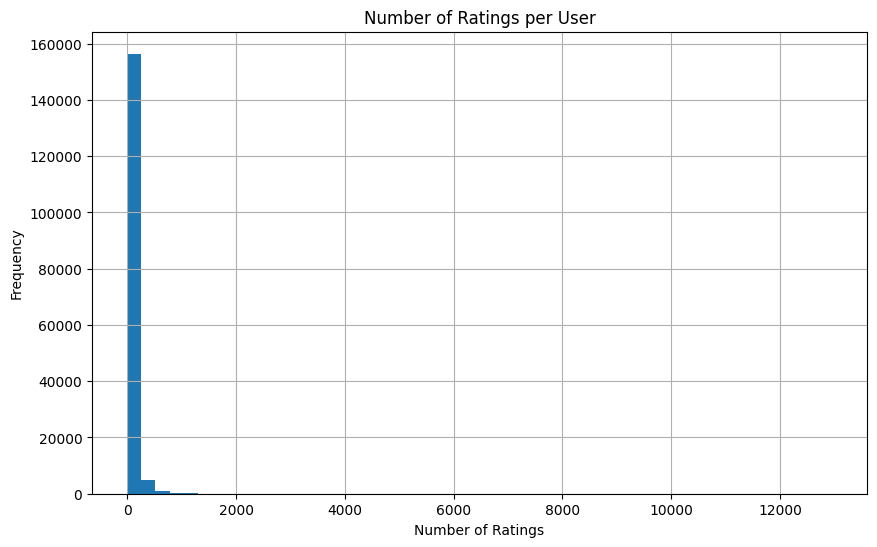

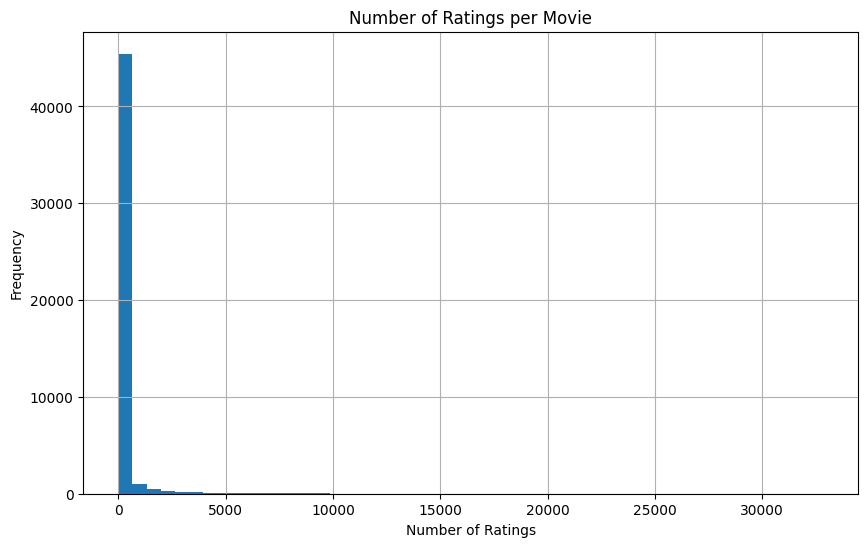

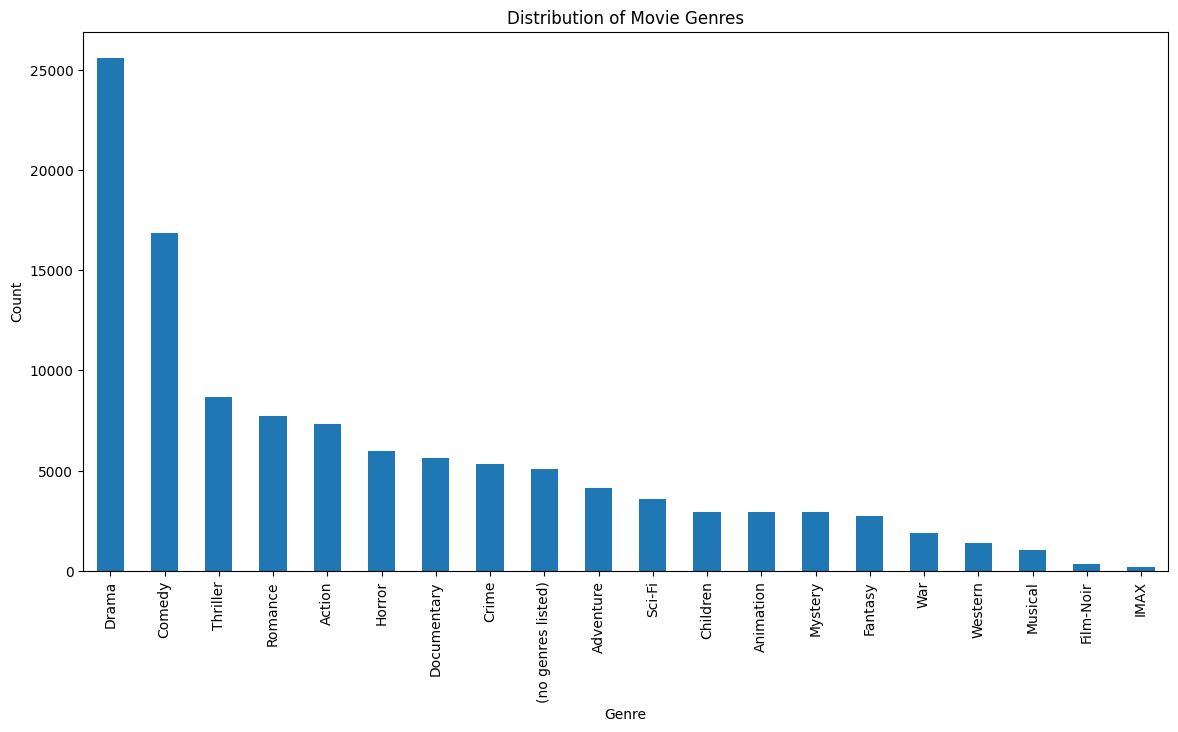

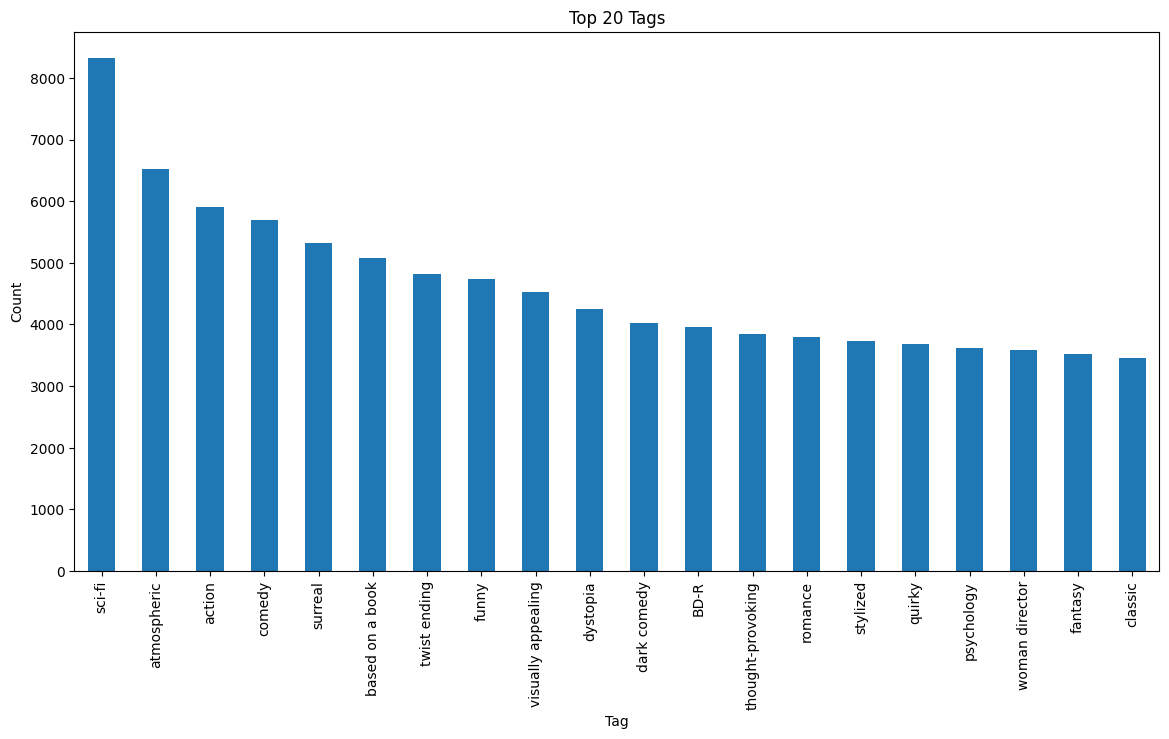

In [7]:

# Step 2: Exploratory Data Analysis (EDA)

# Analyze the distribution of ratings
plt.figure(figsize=(10, 6))
train['rating'].hist(bins=50)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Visualize the number of ratings per user
ratings_per_user = train.groupby('userId').size()
plt.figure(figsize=(10, 6))
ratings_per_user.hist(bins=50)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

# Visualize the number of ratings per movie
ratings_per_movie = train.groupby('movieId').size()
plt.figure(figsize=(10, 6))
ratings_per_movie.hist(bins=50)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

# Explore relationships between different features (e.g., genres, tags)
genres = movies['genres'].str.get_dummies('|').sum().sort_values(ascending=False)
plt.figure(figsize=(14, 7))
genres.plot(kind='bar')
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

tags['tag'].value_counts().head(20).plot(kind='bar', figsize=(14, 7))
plt.title('Top 20 Tags')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.show()


In [8]:
# Step 3: Data Cleaning

# Check for missing values
print(train.isnull().sum())
print(test.isnull().sum())
print(movies.isnull().sum())
print(tags.isnull().sum())
print(links.isnull().sum())
print(genome_scores.isnull().sum())
print(genome_tags.isnull().sum())
print(imdb_data.isnull().sum())

# Example of handling missing values in IMDB data
imdb_data.fillna('', inplace=True)  # or use other imputation methods

# Ensure data types are correct
train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

# Encode genres as a list
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
userId     0
movieId    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64
movieId      0
imdbId       0
tmdbId     107
dtype: int64
movieId      0
tagId        0
relevance    0
dtype: int64
tagId    0
tag      0
dtype: int64
movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64


In [9]:
# Step 4: Feature Engineering

# Example: Average rating per movie
movie_avg_rating = train.groupby('movieId')['rating'].mean().reset_index()
movie_avg_rating.columns = ['movieId', 'avg_rating']

# Example: Number of ratings per movie
movie_rating_count = train.groupby('movieId')['rating'].count().reset_index()
movie_rating_count.columns = ['movieId', 'rating_count']

# Merge these features with the original movies dataframe
movies = movies.merge(movie_avg_rating, on='movieId', how='left')
movies = movies.merge(movie_rating_count, on='movieId', how='left')

In [10]:
# Step 5: Model Building

# Load the data into Surprise format
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)

# Use SVD algorithm for recommendation
svd = SVD()

# Evaluate the model
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Step 6: Prediction and Submission

# Train the model on the entire dataset
trainset = data.build_full_trainset()
svd.fit(trainset)

# Predict ratings for the test set
test['rating'] = test.apply(lambda x: svd.predict(x['userId'], x['movieId']).est, axis=1)

# Create submission file
test['Id'] = test['userId'].astype(str) + '_' + test['movieId'].astype(str)
submission = test[['Id', 'rating']]

# Save to CSV
submission.to_csv('submission.csv', index=False)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8329  0.8351  0.8352  0.8349  0.8327  0.8342  0.0011  
MAE (testset)     0.6322  0.6336  0.6341  0.6335  0.6323  0.6331  0.0007  
Fit time          251.65  256.36  262.42  264.22  261.09  259.15  4.56    
Test time         56.30   46.68   51.36   49.65   53.68   51.53   3.30    


In [11]:
submission.to_csv('/content/sample_data/submission.csv', index=False)

Mounted at /content/drive
